In [56]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [27]:
url = 'http://mattmahoney.net/dc/'

def download(filename, expected_bytes):
    """Download the file if it's not present and make sure it's the right size"""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statsinfo = os.stat(filename)
    if statsinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statsinfo.st_size)
        raise Exception(
        'Failed to verify ' + filename + '.Get it with a browser.')
    return filename

filename = download('text8.zip', 31344016)
        

Found and verified text8.zip


In [28]:
def read_data(filename):
    """Extract the first file enclosed in the zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [29]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        #storing the index
        #maps common word to index in count
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 #'UNK' has index 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)    

In [30]:
dictionary['UNK']

0

In [31]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words 

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [34]:
#Function to generate a training batch for a skipgram model

data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    span = 2*skip_window + 1 #[ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in xrange(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window #target is at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips +j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels    

In [35]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2,1), (4,2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nWith num_skips = %d, skip_window = %d:' % (num_skips, skip_window))
    print('     batch:', [reverse_dictionary[bi] for bi in batch])
    print('     labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

With num_skips = 2, skip_window = 1:
     batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
     labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a']

With num_skips = 4, skip_window = 2:
     batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
     labels: ['a', 'term', 'originated', 'anarchism', 'term', 'as', 'of', 'originated']


In [36]:
#Train the skip-gram model
batch_size = 128
embedding_size = 128 #Dimension of the embedding vector
skip_window = 1 # words to consider on left and right
num_skips = 2 # how many times to reuse an input to generate a label 
              #(or total number of neighours to pick)
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 #Number of negative examples to sample

graph = tf.Graph()
with graph.as_default():
    
    #input data
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    #Variables
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                       stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    #Model
    #Look up for embedding for inputs
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    #Compute the softmax loss using a sample of negative labels each time
    loss = tf.reduce_mean(
           tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, 
                                   inputs=embed, labels=train_labels, 
                                   num_sampled=num_sampled, num_classes=vocabulary_size))
    
    #Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    #Compute the similarity between the minibatch examples and all embeddings.
    #We are using cosine distance here
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [38]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print ('Initialized')
    average_loss = 0
    for step in xrange(num_steps):
        batch_data, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data,
                    train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
        if step  % 1000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 #number of nearest neighbours
                nearest = (-sim[i, : ]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()    
                

Initialized
Nearest to zero: subscriber, nominated, beaumont, voigt, generally, fatally, lyrics, reconstructionist,
Nearest to they: maximize, poke, hain, backlit, revamped, stepney, riverboat, peake,
Nearest to seven: finder, donaldson, paramilitary, sponsor, lenovo, motel, testifying, glad,
Nearest to their: inducted, piston, outermost, veneto, burgh, petacci, resolutions, liu,
Nearest to d: fay, hordes, bartolom, strangelove, imminent, phidias, musics, minute,
Nearest to one: nevada, balanced, voris, priorities, kde, married, discrepancies, tissot,
Nearest to american: dominatrix, pyrrhus, koh, lecter, indira, breast, genevieve, ici,
Nearest to five: numerology, ngel, biarritz, proteus, speedway, di, lean, vlaams,
Nearest to UNK: voiced, diphtheria, humourous, saloon, narrates, attendees, centuries, broad,
Nearest to eight: obsessive, mekong, disclaimed, antoni, connectors, dianetic, ephemeral, alomar,
Nearest to about: skip, promise, dinosaurs, hermione, userland, wills, masturbati

In [42]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

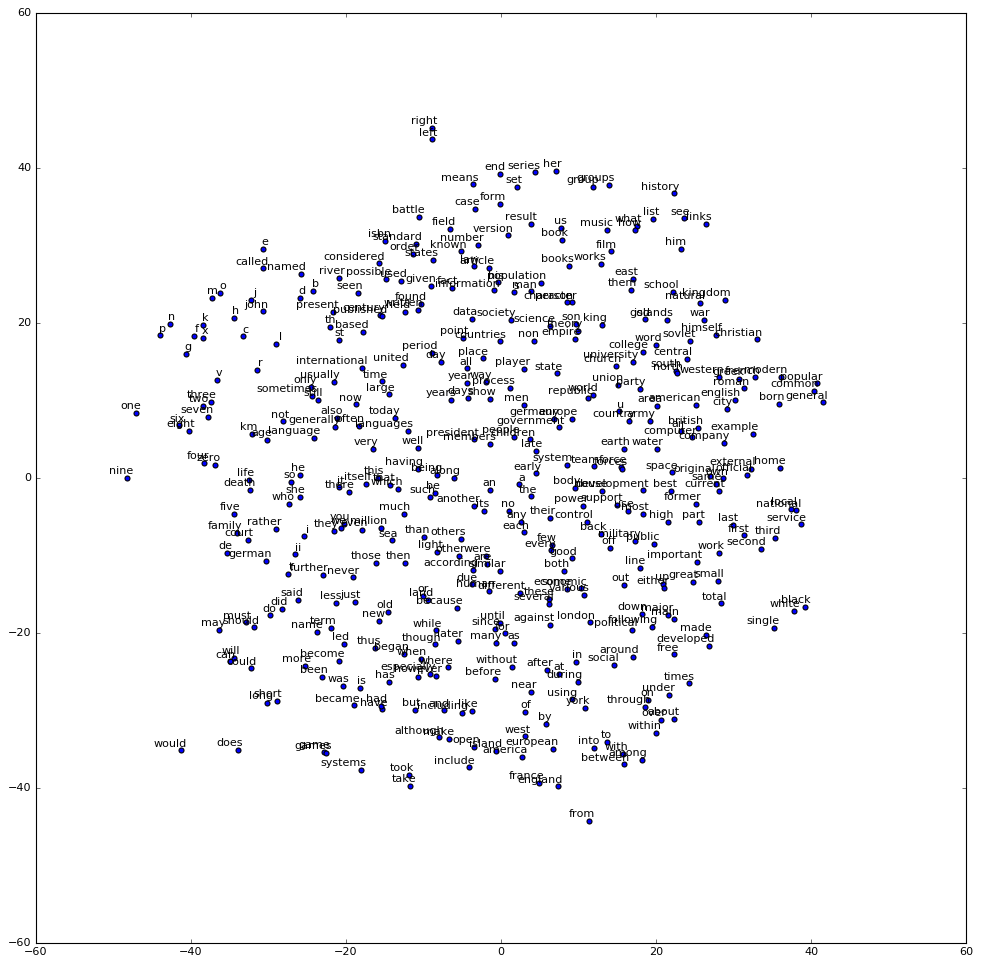

In [40]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                     ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [23]:
a = '%s %s,' % ('', 'd')  

In [43]:
tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000, method='exact')
three_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

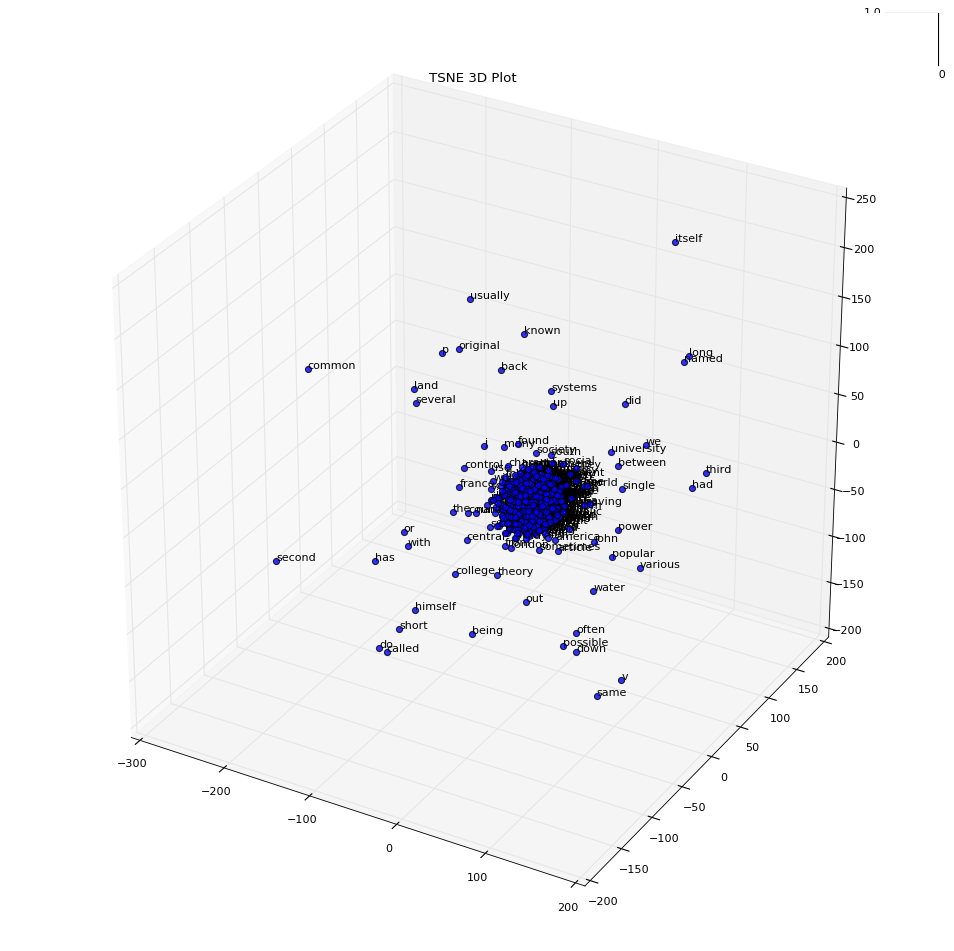

In [55]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    fig = plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(15, 15, 15, axisbg="1.0")
    ax = fig.gca(projection='3d')
    for i, label in enumerate(labels):
        x, y, z = embeddings[i,:]
        ax.scatter(x, y, z, alpha=0.8, edgecolors='none', s=30, label=label)
        ax.text(x, y, z,  '%s' % (label), size=10, zorder=1,color='k') 
        
    plt.title('TSNE 3D Plot')
    #plt.legend(loc=2)
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(three_d_embeddings, words)